Reliance Data Head:
               Close      High       Low      Open       Volume
Date                                                           
1996-01-01  3.952677  3.959400  3.912334  3.938269  104121369.0
1996-01-02  3.921939  3.962282  3.893122  3.943071  168743308.0
1996-01-03  3.951717  4.167841  3.943072  3.986296  209323879.0
1996-01-04  3.915215  3.926742  3.862385  3.914255  216900264.0
1996-01-05  3.888321  3.899848  3.854702  3.899848  166708467.0


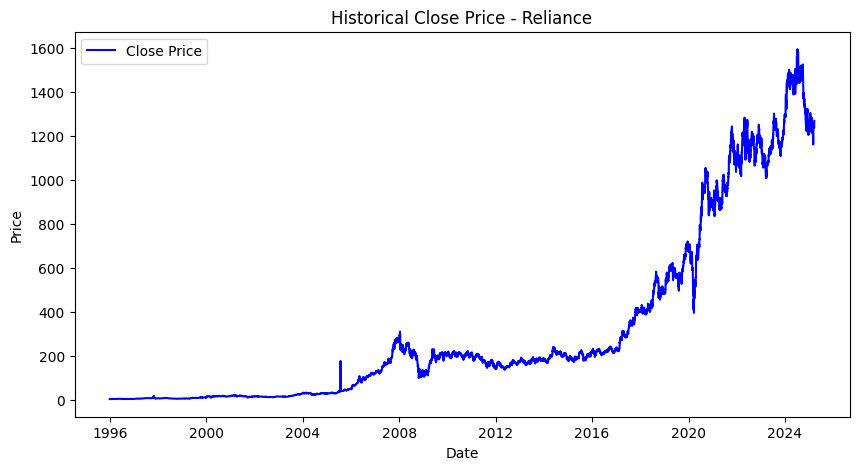

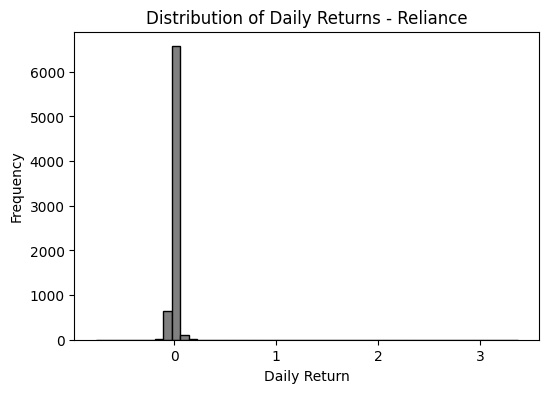


Training model for TCS...


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 36s 212ms/step - loss: 1.1429 - val_loss: 0.4501
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - loss: 0.5252 - val_loss: 0.1412
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - loss: 0.3799 - val_loss: 0.1086
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 210ms/step - loss: 0.2866 - val_loss: 0.0440
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - loss: 0.2146 - val_loss: 0.0233
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - loss: 0.1568 - val_loss: 0.0067
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 214ms/step - loss: 0.1032 - val_loss: 0.0372
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 35s 253ms/step - loss: 0.0742 - val_loss: 0.0356
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 36s 260ms/step - loss: 0.0548 - val_loss: 0.0395
Epoch 10/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 33s 234ms/step - loss: 0.0353 - val_loss: 0.0375
Epoch 11/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 221ms/step - loss: 0.0254 - val_loss: 0.0456
Epoch 12/50
139/139

c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 51s 242ms/step - loss: 0.9187 - val_loss: 0.0837
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.3879

In [ ]:
# %% [markdown]
# # Stock and Index Forecasting with Improved LSTM Models
#
# This notebook loads CSV files for various stocks and indices, preprocesses the data, 
# trains improved stacked LSTM models for forecasting, evaluates model performance, 
# and saves the trained models for future inference.
#
# **Assets Covered:**
# - **Stocks:** TCS, RELIANCE, HDFCBANK
# - **Indices:** NIFTY_50, NIFTY_500, NIFTY_Bank, NIFTY_FMCG, NIFTY_IT, NIFTY_Midcap_100
#
# Adjust file paths as needed. The CSV files are assumed to have extra header rows, so we skip rows and rename columns.

# %% [code]
# Necessary imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam

# (Optional) If you still want to use KerasTuner, install it (but you may remove tuning cells later)
# !pip install keras-tuner -q

# %% [markdown]
# ## 1. Data Loading and Preprocessing
#
# We load CSV files for each asset. The CSV files have extra header rows that are skipped.
# We then rename columns to `['Date', 'Close', 'High', 'Low', 'Open', 'Volume']`, convert the Date to datetime,
# sort the data, set the Date as index, and drop any missing rows.

# %% [code]
# Define asset filepaths (adjust paths as needed)
assets = {
    'TCS': 'nse/TCS.csv',
    'Reliance': 'nse/RELIANCE.csv',
    'HDFCBANK': 'nse/HDFCBANK.csv',
    'NIFTY_50': 'indices/NIFTY_50.csv',
    'NIFTY_500': 'indices/NIFTY_500.csv',
    'NIFTY_Bank': 'indices/NIFTY_Bank.csv',
    'NIFTY_FMCG': 'indices/NIFTY_FMCG.csv',
    'NIFTY_IT': 'indices/NIFTY_IT.csv',
    'NIFTY_Midcap_100': 'indices/NIFTY_Midcap_100.csv'
}

data_dict = {}
for name, filepath in assets.items():
    # Read the CSV file by skipping the first two rows and assign new column names.
    df = pd.read_csv(filepath, skiprows=2, 
                     names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'])
    # Remove any row where the first column still contains the string "Date"
    df = df[df['Date'] != 'Date']
    
    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    
    # Sort by date, set index, and drop any remaining missing values
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)
    df = df.dropna()
    
    data_dict[name] = df

# Display the first few rows for one asset as an example
print("Reliance Data Head:")
print(data_dict['Reliance'].head())

# %% [markdown]
# ## 2. Exploratory Data Analysis (EDA)
#
# We plot the historical closing price and the distribution of daily returns for an example asset (Reliance).

# %% [code]
asset = 'Reliance'
df = data_dict[asset]

plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title(f'Historical Close Price - {asset}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Daily returns
df['Daily_Return'] = df['Close'].pct_change()
plt.figure(figsize=(6, 4))
plt.hist(df['Daily_Return'].dropna(), bins=50, color='grey', edgecolor='black')
plt.title(f'Distribution of Daily Returns - {asset}')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

# %% [markdown]
# ## 3. Data Preprocessing for LSTM
#
# We define a helper function to convert a univariate time series (here, 'Close') into sequences.
# Each input sequence of length `time_steps` is used to predict the next value.

# %% [code]
def preprocess_lstm_data(df, feature='Close', time_steps=60):
    data = df[[feature]].values  # shape (n_samples, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i-time_steps:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    # Reshape to 3D array: (samples, time_steps, 1)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y, scaler

# %% [markdown]
# ## 4. Improved LSTM Model
#
# We build an improved stacked LSTM model with three LSTM layers (the first two bidirectional),
# dropout and batch normalization, a lower learning rate, and more epochs.

# %% [code]
def build_improved_lstm_model(time_steps, input_dim=1, 
                              units1=256, units2=128, units3=64, 
                              dropout_rate=0.3, learning_rate=0.0005):
    model = Sequential()
    # First LSTM layer (Bidirectional)
    model.add(Bidirectional(LSTM(units1, return_sequences=True), 
                            input_shape=(time_steps, input_dim)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    # Second LSTM layer (Bidirectional)
    model.add(Bidirectional(LSTM(units2, return_sequences=True)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    # Third LSTM layer (unidirectional)
    model.add(LSTM(units3, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    # Dense output layer for regression
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# %% [markdown]
# ## 5. Training and Evaluation Function
#
# We define a function that preprocesses the data, splits it into training, validation, and test sets,
# builds and trains the improved LSTM model, and then evaluates its performance.

# %% [code]
def train_and_evaluate_improved_model(asset_name, df, time_window=60):
    # Preprocess data
    X, y, scaler = preprocess_lstm_data(df, feature='Close', time_steps=time_window)
    
    # Split into train (80%), validation (10%), test (10%)
    train_size = int(len(X) * 0.8)
    X_train, X_temp = X[:train_size], X[train_size:]
    y_train, y_temp = y[:train_size], y[train_size:]
    val_size = int(len(X_temp) * 0.5)
    X_val, X_test = X_temp[:val_size], X_temp[val_size:]
    y_val, y_test = y_temp[:val_size], y_temp[val_size:]
    
    # Build the improved model
    model = build_improved_lstm_model(time_steps=time_window, input_dim=1,
                                      units1=256, units2=128, units3=64, 
                                      dropout_rate=0.3, learning_rate=0.0005)
    
    # Train the model (increase epochs for better convergence)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                        validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    predictions = model.predict(X_test)
    pred_prices = scaler.inverse_transform(predictions)
    actual_prices = scaler.inverse_transform(y_test.reshape(-1,1))
    
    rmse = np.sqrt(mean_squared_error(actual_prices, pred_prices))
    mae = mean_absolute_error(actual_prices, pred_prices)
    mape = np.mean(np.abs((actual_prices - pred_prices) / actual_prices)) * 100
    print(f"{asset_name} - Improved Model RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
    
    return model, scaler, actual_prices, pred_prices

# %% [markdown]
# ## 6. Training Models for All Assets
#
# We iterate over each asset, train the improved LSTM model, and store the trained model and scaler.

# %% [code]
trained_models = {}
scalers = {}
results = {}  # store test set actual vs. predicted for evaluation

for name, df in data_dict.items():
    print(f"\nTraining model for {name}...")
    model, scaler, actual, preds = train_and_evaluate_improved_model(name, df, time_window=60)
    trained_models[name] = model
    scalers[name] = scaler
    results[name] = {'actual': actual, 'predicted': preds}

# %% [markdown]
# ## 7. Forecasting Future Prices
#
# We define a function to perform a rolling forecast for the next 30 days.
# The forecast is done recursively by using the last `time_window` days to predict one day ahead,
# then appending that prediction to the sequence for subsequent predictions.

# %% [code]
def forecast_future(model, scaler, last_sequence, n_steps):
    seq = last_sequence.copy()
    predictions = []
    for _ in range(n_steps):
        seq_scaled = scaler.transform(seq.reshape(-1, 1))
        X_input = seq_scaled.reshape(1, seq_scaled.shape[0], 1)
        y_pred_scaled = model.predict(X_input, verbose=0)
        y_pred = scaler.inverse_transform(y_pred_scaled)[0, 0]
        predictions.append(y_pred)
        seq = np.append(seq[1:], [[y_pred]], axis=0)
    return np.array(predictions)

# %% [markdown]
# ### Example: Forecast Next 30 Days for Reliance
# 
# We use the last 60 days of Reliance data to forecast the next 30 days.

# %% [code]
asset = 'Reliance'
df_reliance = data_dict[asset]
last_seq = df_reliance[['Close']].values[-60:]
future_forecast = forecast_future(trained_models[asset], scalers[asset], last_seq, n_steps=30)
print(f"Next 30-day forecast for {asset}:")
print(future_forecast)

# Plot the forecast along with recent history
history = df_reliance['Close'][-100:]  # last 100 days for context
last_date = df_reliance.index[-1]
future_dates = pd.bdate_range(last_date, periods=31, freq='B')[1:]  # 30 business days after last_date
plt.figure(figsize=(10,5))
plt.plot(history.index, history.values, label='Historical', color='blue')
plt.plot(future_dates, future_forecast, label='Forecast', color='green')
# Using the RMSE of Reliance as a rough uncertainty band
rmse_val = np.sqrt(mean_squared_error(results[asset]['actual'], results[asset]['predicted']))
plt.fill_between(future_dates, future_forecast - rmse_val, future_forecast + rmse_val, color='lightgreen', alpha=0.5, label='Uncertainty (±RMSE)')
plt.title(f"{asset} - 30-Day Price Forecast")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 8. Comparing Performance Across Assets
#
# We compile the performance metrics (RMSE, MAE, MAPE) into a summary table and visualize them.

# %% [code]
metrics_summary = []
for name, res in results.items():
    actual = res['actual']
    pred = res['predicted']
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    metrics_summary.append([name, rmse, mae, mape])
    
metrics_df = pd.DataFrame(metrics_summary, columns=['Asset', 'RMSE', 'MAE', 'MAPE'])
print(metrics_df)

plt.figure(figsize=(8,4))
plt.bar(metrics_df['Asset'], metrics_df['MAPE'], color='skyblue')
plt.title('Model Performance (MAPE) by Asset')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 9. Saving Trained Models and Scalers
#
# We save each trained model and its scaler to the `models/` directory for future inference.

# %% [code]
os.makedirs('models', exist_ok=True)
import pickle
for name, model in trained_models.items():
    model.save(f'models/{name}_LSTM_model.h5')
    with open(f'models/{name}_scaler.pkl', 'wb') as f:
        pickle.dump(scalers[name], f)
print("Models and scalers saved to the 'models/' directory.")

# %% [markdown]
# ## 10. Utility Functions for Inference
#
# These functions allow you to load a saved model and its scaler, and make new predictions.

# %% [code]
def load_model_and_scaler(asset_name):
    model = load_model(f'models/{asset_name}_LSTM_model.h5')
    with open(f'models/{asset_name}_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    return model, scaler

def predict_next_n_days(asset_name, recent_data, n_days=30):
    model, scaler = load_model_and_scaler(asset_name)
    return forecast_future(model, scaler, recent_data, n_days)

# Example: Predict next 5 days for Reliance
recent_seq = df_reliance[['Close']].values[-60:]
predicted_next_5 = predict_next_n_days('Reliance', recent_seq, n_days=5)
print("Next 5-day prediction for Reliance:")
print(predicted_next_5)
